In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, resample, envelope

from risotto.rtf import estimate_rtf
from risotto.utils.dsp_utils import stft, istft

from brioche.beamformer import DS, MVDR, LCMV, GSC
from brioche.utils.dsp_utils import diffuse_noise

# the case of absolute metrics
import speechmetrics

/home/ddicarlo/Documents/Code/InProgress/2019@Barilan_dataset_dechorate/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
from IPython.display import Audio

In [4]:
def plt_time_signal(signal, samplig_freq, **kvargs):
    return plt.plot(np.arange(len(signal))/samplig_freq, signal, **kvargs)

In [5]:
curr_dir = '../recipes/echo_aware_processing/'
data_filename = curr_dir + 'data_notebook.pkl'

# Get the data: RIRs and Annotation

Surf the dEchorate and load the RIRs and the correspondent annotation

In [6]:
dataset_dir = '../data/dECHORATE/'
path_to_processed = '../data/processed/'
path_to_note_csv = dataset_dir + 'annotations/dECHORATE_database.csv'
path_to_after_calibration = path_to_processed + 'post2_calibration/calib_output_mics_srcs_pos.pkl'

# Some constant of the dataset
L = constants['rir_length']
Fs = constants['Fs']
c = constants['speed_of_sound']
L = constants['rir_length']
datasets_name = constants['datasets'][:6]
D = len(datasets_name)

# Annotation, RIRs from measurements, 'equivalent' synthetic RIRs
note_dict = load_from_pickle(path_to_after_calibration)
rdset = DechorateDataset(path_to_processed, path_to_note_csv)
sdset = SyntheticDataset()
note_dict.keys()

dict_keys(['mics', 'srcs', 'toa_pck', 'toa_sym', 'rirs'])

## Simulation parameters

In [7]:
# which dataset?
d = 3

# which array?
arr_idx = 5

mics_idxs = [(5*arr_idx + i) for i in range(5)]
print(mics_idxs)
I = len(mics_idxs)
# which one is the reference mic?
ref_mic = 4
r = ref_mic
print(mics_idxs[ref_mic])

# which source?
srcs_idxs = [0, 1]
J = len(srcs_idxs)
# which src is the one to enhance?
t = 0 # the target
q = 1 # the interf

# how many echoes to rake?
K = 7 # all the first 7
# in which order?
ordering = 'reflection' # earliest, strongest, order

[25, 26, 27, 28, 29]
29


In [8]:
dset = datasets_name[d]
print(dset)

rirs_real = np.zeros([L, I, J])
rirs_synt = np.zeros([L, I, J])
mics = np.zeros([3, I])
srcs = np.zeros([3, J])
toas = np.zeros([K, I, J])
toas_synt = np.zeros([K, I, J])
toas_peak = np.zeros([K, I, J])
toas_cmds = np.zeros([K, I, J])
amps_cmds = np.zeros([K, I, J])

for i, m in enumerate(mics_idxs):
    for j, s in enumerate(srcs_idxs):

        # get rir from the recondings
        rdset.set_dataset(dset)
        rdset.set_entry(m, s)
        mic, src = rdset.get_mic_and_src_pos()
        _, rrir = rdset.get_rir()

        # measure after calibration
        mics[:, i] = note_dict['mics'][:, m]
        srcs[:, j] = note_dict['srcs'][:, s]

        # get synthetic rir
        sdset = SyntheticDataset()
        sdset.set_room_size(constants['room_size'])
        sdset.set_dataset(dset, absb=0.90, refl=0.2)
        sdset.set_c(c)
        sdset.set_fs(Fs)
        sdset.set_k_order(3)
        sdset.set_k_reflc(1000)
        sdset.set_mic(mics[0, i], mics[1, i], mics[2, i])
        sdset.set_src(srcs[0, j], srcs[1, j], srcs[2, j])
        tk, ak = sdset.get_note(ak_normalize=False, tk_order=ordering)
        
        _, srir = sdset.get_rir(normalize=False)
        
        ak = ak / (4 * np.pi)
        srir = srir / (4 * np.pi)

            
        Ls = min(len(srir), L)
        Lr = min(len(rrir), L)

        # measure after calibration
        rirs_real[:Lr, i, j] = rrir[:Lr]
        rirs_synt[:Ls, i, j] = srir[:Ls]

        toas_peak[:K, i, j] = note_dict['toa_pck'][:K, m, s]
        toas_cmds[:K, i, j] = tk[:K]
        amps_cmds[:K, i, j] = ak[:K]

print('done with the extraction')
rirs_real = np.squeeze(rirs_real)
rirs_synt = np.squeeze(rirs_synt)

data = {
    'rirs_real' : rirs_real,
    'rirs_synt' : rirs_synt,
    'mics' : mics,
    'srcs' : srcs,
    'toas_synt' : toas_cmds,
    'amps_synt' : amps_cmds,
    'toas_peak' : toas_peak,
    'amps_peak' : None,
    'Fs' : Fs,
}


save_to_pickle(data_filename, data)
print('Saved.')

011100
done with the extraction
Saved.


### Plot audio scene

In [9]:
mic_pos = mics
mic_pos

array([[3.08212703, 3.04939035, 3.00846949, 2.95527238, 2.87343067],
       [3.42108318, 3.44406817, 3.4727994 , 3.51015   , 3.56761246],
       [1.49048013, 1.49048013, 1.49048013, 1.49048013, 1.49048013]])

In [10]:
arr_pos = np.mean(mics, 1)
arr_pos

array([2.99373799, 3.48314264, 1.49048013])

In [11]:
tgt_pos = srcs[:, 0:1]
tgt_pos

array([[1.89407487],
       [4.52190448],
       [1.4481839 ]])

In [12]:
itf_pos = srcs[:, 1:2]
itf_pos

array([[1.6330509 ],
       [0.8420041 ],
       [1.02493109]])

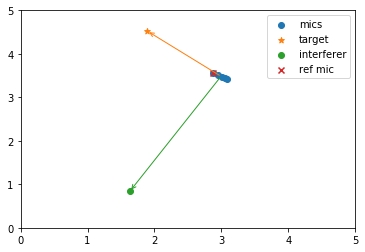

In [13]:
plt.scatter(mic_pos[0,:], mic_pos[1,:], label='mics')
plt.scatter(tgt_pos[0,:], tgt_pos[1,:], label='target', marker='*')
plt.scatter(itf_pos[0,:], itf_pos[1,:], label='interferer')
plt.annotate('',
             (arr_pos[0], arr_pos[1]), 
             (tgt_pos[0], tgt_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C1'})
plt.annotate('', 
             (arr_pos[0], arr_pos[1]), 
             (itf_pos[0], itf_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C2'})
plt.scatter(mic_pos[0,r], mic_pos[1,r], marker='x', label='ref mic')
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.legend()
plt.show()

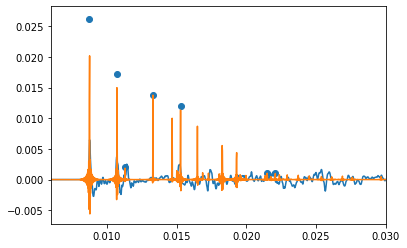

In [14]:
# Plot on sample
i, j = (4, 1)

a = np.max(np.abs(rirs_real[:, i, j]))
t1  = np.argmax(rirs_synt[:, i, j])/Fs
toa = toas_cmds[:, i, j]
amp = amps_cmds[:, i, j]

L = len(rirs_real[:, i, j])
time = np.arange(L)/Fs

plt_time_signal(rirs_real[:, i, j], Fs)
plt_time_signal(rirs_synt[:, i, j], Fs)
plt.scatter(toa, amp)
plt.xlim(0.006, 0.03)
plt.show()

## Restore amplitudes with Condat's formula

In [15]:
# restore echoes' amplitudes from the echoes' location
amps_condat = np.zeros_like(toas_cmds)
for j in range(J):
    for i in range(I):
            
        tk = toas_cmds[:, i, j]
        L = int(np.max(toas_cmds[:, i, j])*Fs)+500
        max_tau = L/Fs

        rir = rirs_real[:L, i, j]
        v = np.fft.fft(rir)

        M = (len(v)-1)/2
        MM = np.arange(-M,M+1)

        assert -MM[0] == MM[-1]
        assert len(MM) == len(v)

        U = np.exp(-1j*2*np.pi*MM[:,None]@tk[None,:]/max_tau)
        ak = np.abs(np.linalg.lstsq(U, v, rcond=None)[0])

        amps_condat[:, i, j] = ak
            
#             plt.plot(np.arange(L)/Fs, rir)
#             plt.scatter(tk, ak, c='C1', marker='x')
#             plt.show()

data['amps_peak'] = amps_condat
# scale synthetic echoes' amplitudes according to the measured rirs

In [16]:
# restore amps based on direct path eight
amps = np.zeros_like(toas_synt)
for j in range(J):
    for i in range(I):
        t = int(toas_peak[0, i, j]*Fs)
        a = np.max(np.abs(rirs_real[t-40:t+40, i, j]))
        amps[:, i, j] = a * (amps_cmds[:, i, j] / np.max(np.abs(amps_cmds[:, i, j])))

data['amps_synt'] = amps

In [17]:
# restore amps based on direct path eight
amps_rirs = np.zeros_like(toas_synt)
for j in range(J):
    for i in range(I):
        print(i, j)
        for k in range(K):
            t = int(toas_peak[k, i, j]*Fs)
            a = np.max(np.abs(rirs_real[t-5:t+5, i, j]))
            amps_rirs[k, i, j] = a
            
#         plt.scatter(toas_peak[:, i, j]*Fs, amps_rirs[:, i, j])
#         plt.plot(np.abs(rirs_real[:, i, j]))
#         plt.xlim([250, 1000])
#         plt.show()
        
data['amps_peak'] = amps_rirs

0 0
1 0
2 0
3 0
4 0
0 1
1 1
2 1
3 1
4 1


# Load the Real Data
load samples from the WSJ dataset and convolve in with the rirs

In [18]:
data_dir = curr_dir + 'TIMIT_long_nili/'
s1m = data_dir + 'DR5_MHMG0_SX195_SX285_SX375_7s.wav'
s2m = data_dir + 'DR7_MGAR0_SX312_SX402_7s.wav'
s1f = data_dir + 'DR1_FTBR0_SX201_SI921_7s.wav'
s2f = data_dir + 'DR4_FKLC0_SI985_SI2245_7s.wav'

files = [s1m, s2m, s1f, s2f]
N = len(files)

In [19]:
wavs = []
for file in files:
    wav, fs = sf.read(file)
    assert len(wav.shape) == 1
    wavs.append(wav[:7*fs])
print('done.')
print('Audio rate is', fs)

done.
Audio rate is 16000


# Make Audio Scene

4
0


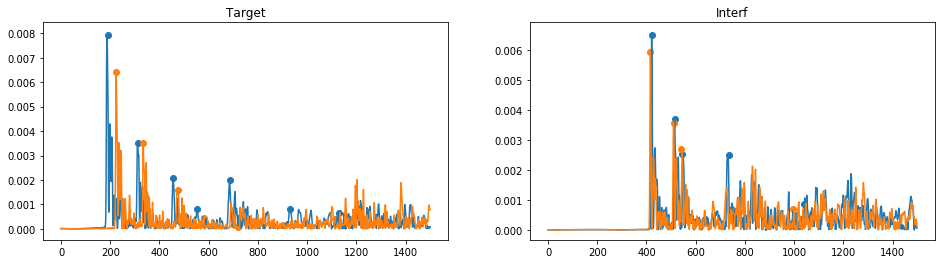

In [20]:
# which rirs?
h_ = data['rirs_real'] # real rirs

# which toas?
toas = toas_peak
# which amps?
amps = data['amps_peak']

r = ref_mic # reference mic

inr = 15 # dB
snr = 15 # dB
sir = snr - inr # dB

print(r)
print(sir)

i = 0

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('Target')
plt.plot(np.abs(h_[:1500, r, 0]))
plt.scatter(toas[:, r, 0]*Fs, amps[:, r, 0])
plt.plot(np.abs(h_[:1500, i, 0]))
plt.scatter(toas[:, i, 0]*Fs, amps[:, i, 0])

plt.subplot(122)
plt.title('Interf')
plt.plot(np.abs(h_[:1500, r, 1]))
plt.scatter(toas[:, r, 1]*Fs, amps[:, r, 1])
plt.plot(np.abs(h_[:1500, i, 1]))
plt.scatter(toas[:, i, 1]*Fs, amps[:, i, 1])
plt.show()


# Make Mixtures

/home/ddicarlo/Documents/Code/InProgress/2019@Barilan_dataset_dechorate/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


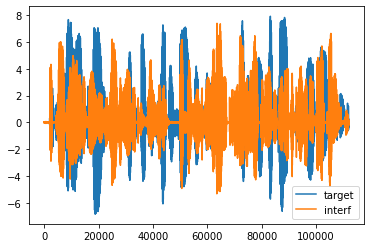

In [21]:
s1 = wavs[0]
s2 = wavs[2]

# center and scale for unit variance
ss1 = (s1-np.mean(s1))/np.std(s1)
ss2 = (s2-np.mean(s2))/np.std(s2)
assert len(ss1) == len(ss2)

plt.plot(ss1, label='target')
plt.plot(ss2, label='interf')
plt.legend()
plt.show()

In [ ]:
# Upsampling and stacking
print(fs, '-->', Fs)
s_ = np.concatenate([resample(ss1, fs, Fs)[:, None], 
                     resample(ss2, fs, Fs)[:, None]], axis=1)
print(s_.shape)

Lc = 10*fs
c_ = np.zeros([Lc, I, J])

# Convolution, downsampling and stacking
print(Fs, '-->', fs)
for i in range(I):
    for j in range(J):
        cs = np.convolve(h_[:, i, j], s_[:, j], 'full')
        cs = resample(cs, Fs, fs)
        L = len(cs)
        print(i, j, L)
        c_[:L, i, j] = cs
        
print('Done.')

16000 --> 48000


In [ ]:
plt.plot(np.arange(len(s_[:, 0]))/Fs, s_[:, 0], label='target')
plt.plot(np.arange(len(c_[:, r, 0]))/fs, c_[:, r, 0], label='image', alpha=0.7)
plt.xlim([6.8, 7.2])
plt.ylim([-3, 3])
plt.legend()
plt.show()

print('Source')
display(Audio(s_[:, 0], rate=Fs))
print('Image')
display(Audio(c_[:, r, 0], rate=fs))

In [ ]:
# Standardization wtr reference microphone
sigma_target = np.std(c_[:7*fs, r, 0])
sigma_interf = np.std(c_[:7*fs, r, 1])

c_[:, :, 0] = c_[:, :, 0] / sigma_target
c_[:, :, 1] = c_[:, :, 1] / sigma_interf

# hereafter we assume that the two images have unit-variance at the reference microphone

In [ ]:
plt_time_signal(c_[:, r, 0], fs, label='target')
plt_time_signal(c_[:, r, 1], fs, label='interf')
plt.legend()
plt.show()

In [ ]:
# lets add some silence and shift the source such that there is overlap
cs1 = np.concatenate([np.zeros([2*fs, I]), c_[:, :, 0], np.zeros([4*fs, I]), np.zeros([2*fs, I])], axis=0)
cs2 = np.concatenate([np.zeros([2*fs, I]), np.zeros([4*fs, I]), c_[:, :, 1], np.zeros([2*fs, I])], axis=0)
# diffuse noise field simulation given the array geometry
dn = diffuse_noise(mic_pos, cs1.shape[0], fs, c=343, N=32, mode='sphere').T
assert dn.shape == cs1.shape
# and unit-variance with respect to the ref mic
dn = dn / np.std(dn[:, r])

In [ ]:
plt.plot(cs1[:, r], label='target')
plt.plot(cs2[:, r], label='interf')
plt.plot(dn[:, r], label='mnoise')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def todB(x):
    return 10*np.log10(x)

In [ ]:
# # proof of the SIR/SNR/INR derivation
# a = np.random.random(L)
# b = np.random.random(L)
# c = np.random.random(L)

# snr = 40
# inr = 2
# sir = snr - inr

# sigma_n = np.sqrt(10 ** (- snr / 10))
# sigma_i = np.sqrt(10 ** (- sir / 10))

# a = (a - np.mean(a))/np.std(a)
# b = sigma_i*(b - np.mean(b))/np.std(b)
# c = sigma_n*(c - np.mean(c))/np.std(c)

# print('SNR', todB(np.var(a)/np.var(c)))
# print('SIR', todB(np.var(a)/np.var(b)))
# print('INR', todB(np.var(b)/np.var(c)))

## Scale according to SNR and INR

In [ ]:
sigma_n = np.sqrt(10 ** (- snr / 10))
sigma_i = np.sqrt(10 ** (- sir / 10))

cs1 = cs1
cdn = sigma_n * dn
cs2 = sigma_i * cs2

In [ ]:
plt_time_signal(cs1[:, r], fs, label='target')
plt_time_signal(cs2[:, r], fs, label='interf')
plt_time_signal(cdn[:, r], fs, label='mnoise')
plt.legend(loc='upper right')
plt.show()

## Mix all together

In [ ]:
# mixing all together 
x = cs1 + cs2 + cdn
plt.plot(x, label='mix')
plt.legend(loc='upper right')
plt.show()

## VAD for RTF computation

In [ ]:
vad = {
    'target' : (int(2*fs), int(4.5*fs)),
    'interf' : (int(10*fs), int(12.5*fs)),
    'noise'  : (int(0.5*fs), int(1.5*fs)),
}

x = cs1 + cs2 + cdn

plt.plot(x[:,r], label='mix')
plt.fill_between(
    np.arange(vad['target'][0], vad['target'][1]), -10, 10,
    color='C12', alpha=0.5, label='VAD target')
plt.fill_between(
    np.arange(vad['interf'][0], vad['interf'][1]), -10, 10,
    color='C13', alpha=0.5, label='VAD interf')
plt.fill_between(
    np.arange(vad['noise'][0], vad['noise'][1]), -10, 10,
    color='C14', alpha=0.5, label='VAD noise')
plt.legend(loc='upper right')
plt.show()

# Spatial Filtering
## params

In [ ]:
assert fs == 16000
nfft = 1024
hop = 512
nrfft = nfft+1
F = nrfft
fstart = 100 # Hz
fend = 6000  # Hz

In [ ]:
print(r)

## STFT

In [ ]:
# stft of the spatial images
CS1 = stft(cs1.T, Fs=Fs, nfft=nfft, hop=hop)[-1]
CS2 = stft(cs2.T, Fs=Fs, nfft=nfft, hop=hop)[-1]
CDN = stft(cdn.T, Fs=Fs, nfft=nfft, hop=hop)[-1]
X = stft(x.T, Fs=Fs, nfft=nfft, hop=hop)[-1]
CS1 =  CS1.transpose([1, 2, 0])
CS2 =  CS2.transpose([1, 2, 0])
CDN =  CDN.transpose([1, 2, 0])
X =  X.transpose([1, 2, 0])

cs1in = istft(CS1[:,:,r], Fs=Fs, nfft=nfft, hop=hop)[-1].real
cs2in = istft(CS2[:,:,r], Fs=Fs, nfft=nfft, hop=hop)[-1].real
cdnin = istft(CDN[:,:,r], Fs=Fs, nfft=nfft, hop=hop)[-1].real


assert np.allclose(X, CS1+CS2+CDN)

In [ ]:
xin = istft(X[:,:,r], Fs=Fs, nfft=nfft, hop=hop)[-1].real
Audio(xin, rate=fs)

## RTF from data

In [ ]:
dRTF = np.zeros([nrfft, I, J], dtype=np.complex)

for j, src in enumerate(['target', 'interf']):
    for i in range(I):
        if i == r:
            dRTF[:, r, j] = np.ones(nrfft)
        else:
            print(vad[src][0], vad[src][1])
            mi = x[vad[src][0]:vad[src][1], i]
            mr = x[vad[src][0]:vad[src][1], r]
#             plt_time_signal(mi, fs)
#             plt_time_signal(mr, fs)
#             plt.show()
            nd = x[vad['noise'][0]:vad['noise'][1], [r, i]]
            dRTF[:, i, j] = estimate_rtf(mi, mr, 'gevdRTF', 'full', Lh=None, n=nd, 
                                         Fs=fs, nfft=nfft, hop=hop)
        print(i)
print('Done.')

## RTF from TDOA

In [ ]:
freqs = np.linspace(0,fs//2,F)
omegas = 2*np.pi*freqs

def rake_filter(ak, tk):
    assert len(ak) == len(tk)
    assert len(ak.shape) == len(tk.shape) == 1
    
    H = np.exp(-1j*omegas[:,None] @ tk[None, :]) @ ak[:, None]
    assert H.shape == (len(omegas), 1)
    
    return H.squeeze()

In [ ]:
eRTF = np.zeros([F, I, J], dtype=np.complex)

for j in range(J):    
    for i in range(I):
        if i == r:
            eRTF[:, r, j] = np.ones(nrfft)
        else:        
            assert len(amps[:, i, j]) == K
            assert len(toas[:, i, j]) == K
            
            Hr = rake_filter(amps[:, r, j], toas[:, r, j])
            Hi = rake_filter(amps[:, i, j], toas[:, i, j])
            eRTF[:, i, j] = Hi / Hr
        
print('Done.')

## Direct-path Steering Vector

In [ ]:
dpTF = np.zeros([F, I, J], dtype=np.complex)

for j in range(J):
    for i in range(I):
        
        Hr = rake_filter(amps[:1, r, j], toas[:1, r, j])
        
        if i == r:
            dpTF[:, r, j] = np.ones(nrfft)
        else:
            Hi = rake_filter(amps[:1, i, j], toas[:1, i, j])
            dpTF[:, i, j] = Hi / Hr
            
print('Done.')

### data-RTF vs echo-RTF vs dpTF

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(np.abs(eRTF[:, 1, 0]), label='echo')
plt.plot(np.abs(dRTF[:, 1, 0]), label='gevd')
plt.ylim([0, 5])
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(np.abs(eRTF[:, 1, 1]), label='echo')
plt.plot(np.abs(dRTF[:, 1, 1]), label='gevd')
plt.ylim([0, 5])
plt.legend(loc='upper left')
plt.show()

In [ ]:
for j in range(J):
    for i in range(I):
        print(np.abs(np.mean(eRTF[:, i, j] - dRTF[:, i, j])))

## Noise Covariance

In [ ]:
Sigma_n = np.zeros([F, I, I], dtype=np.complex64)
for f in range(F):
    Sigma_n[f, :, :] = np.cov(CDN[f, :, :].T)
    
# print(np.mean(np.abs(Sigma_n), axis=0))
plt.imshow(np.mean(np.abs(Sigma_n), axis=0))
plt.show()

# Separation

## Delay and Sum

In [ ]:
X = CS1+CS2+CDN

# separation
bf = DS(name='DS', fstart=fstart,fend=fend, Fs=fs, nrfft=F)
bf.compute_weights(dpTF[:,:,0])
Xout = bf.enhance(X)
CS1out = bf.enhance(CS1)
CS2out = bf.enhance(CS2)
CDNout = bf.enhance(CDN)

# response
print('TARGET', np.mean(np.abs(bf.enhance(dRTF[:,:,0]))))
print('INTERF', np.mean(np.abs(bf.enhance(dRTF[:,:,1]))))

xout = istft(Xout, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs1out = istft(CS1out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs2out = istft(CS2out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cdnout = istft(CDNout, Fs=fs, nfft=nfft, hop=hop)[-1].real

# plot
plt.figure(figsize=(16,4))
plt.plot(xout, label='out')
plt.plot(xin, alpha=0.5, label='in')
plt.legend(loc='upper left')
plt.show()
Audio(xout, rate=fs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(cs1out[2*fs:9*fs], label='cs1 out')
plt.plot(cs1in[2*fs:9*fs], alpha=0.5, label='cs1')
plt.legend(loc='upper left')
plt.subplot(132)
plt.plot(cs2out[6*fs:13*fs], label='cs2 out')
plt.plot(cs2in[6*fs:13*fs], alpha=0.5, label='cs2')
plt.legend(loc='upper left')
plt.subplot(133)
plt.plot(cdnout[2*fs:9*fs], label='cdn out')
plt.plot(cdnin[2*fs:9*fs], alpha=0.5, label='cdn')
plt.legend(loc='upper left')
plt.show()

# metrics
sar_out = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs1out[2*fs:9*fs]))
print('SAR', sar_out)


snr_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cdnin[2*fs:9*fs]))
snr_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cdnout[2*fs:9*fs]))
print('SNR', snr_in, '-->', snr_out, ':', snr_out - snr_in)

sir_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs2in[6*fs:13*fs]))
sir_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cs2out[6*fs:13*fs]))
print('SIR', sir_in, '-->', sir_out, ':', sir_out - sir_in)

# listening
print('Input')
display(Audio(xin, rate=fs))

print('Enhanced ouput')
display(Audio(xout, rate=fs))

## dataRTF-based MVDR

In [ ]:
X = CS1+CS2+CDN

bf = MVDR(name='rtfMVDR', fstart=fstart,fend=fend, Fs=fs, nrfft=nfft + 1)
bf.compute_weights(dRTF[:, :, 0], Sigma_n),

# response
print('DATA', np.mean(np.abs(bf.enhance(dRTF[:,:,0]))), 
      'vs', np.mean(np.abs(bf.enhance(dRTF[:,:,1]))))

# separation
Xout = bf.enhance(X)
CS1out = bf.enhance(CS1)
CS2out = bf.enhance(CS2)
CDNout = bf.enhance(CDN)

xout = istft(Xout, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs1out = istft(CS1out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs2out = istft(CS2out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cdnout = istft(CDNout, Fs=fs, nfft=nfft, hop=hop)[-1].real

# plot
plt.figure(figsize=(16,4))
plt.plot(xout, label='out')
plt.plot(xin, alpha=0.5, label='in')
plt.legend(loc='upper left')
plt.show()
Audio(xout, rate=fs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(cs1out[2*fs:9*fs], label='cs1 out')
plt.plot(cs1in[2*fs:9*fs], alpha=0.5, label='cs1')
plt.legend(loc='upper left')
plt.subplot(132)
plt.plot(cs2out[6*fs:13*fs], label='cs2 out')
plt.plot(cs2in[6*fs:13*fs], alpha=0.5, label='cs2')
plt.legend(loc='upper left')
plt.subplot(133)
plt.plot(cdnout[2*fs:9*fs], label='cdn out')
plt.plot(cdnin[2*fs:9*fs], alpha=0.5, label='cdn')
plt.legend(loc='upper left')
plt.show()

# metrics
sar_out = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs1out[2*fs:9*fs]))
print('SAR', sar_out)


snr_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cdnin[2*fs:9*fs]))
snr_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cdnout[2*fs:9*fs]))
print('SNR', snr_in, '-->', snr_out, ':', snr_out - snr_in)

sir_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs2in[6*fs:13*fs]))
sir_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cs2out[6*fs:13*fs]))
print('SIR', sir_in, '-->', sir_out, ':', sir_out - sir_in)

# listening
print('Input')
display(Audio(xin, rate=fs))

print('Enhanced ouput')
display(Audio(xout, rate=fs))

## ecoRTF-based MVDR

In [ ]:
X = CS1+CS2+CDN

bf = MVDR(name='ecoMVDR', fstart=fstart,fend=fend, Fs=fs, nrfft=F)
bf.compute_weights(eRTF[:, :, 0], Sigma_n),

print('ECHO', np.mean(np.abs(bf.enhance(eRTF[:,:,0]))), 
      'vs', np.mean(np.abs(bf.enhance(eRTF[:,:,1]))))

# separation
Xout = bf.enhance(X)
CS1out = bf.enhance(CS1)
CS2out = bf.enhance(CS2)
CDNout = bf.enhance(CDN)

xout = istft(Xout, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs1out = istft(CS1out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs2out = istft(CS2out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cdnout = istft(CDNout, Fs=fs, nfft=nfft, hop=hop)[-1].real

# plot
plt.figure(figsize=(16,4))
plt.plot(xout, label='out')
plt.plot(xin, alpha=0.5, label='in')
plt.legend(loc='upper left')
plt.show()
Audio(xout, rate=fs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(cs1out[2*fs:9*fs], label='cs1 out')
plt.plot(cs1in[2*fs:9*fs], alpha=0.5, label='cs1')
plt.legend(loc='upper left')
plt.subplot(132)
plt.plot(cs2out[6*fs:13*fs], label='cs2 out')
plt.plot(cs2in[6*fs:13*fs], alpha=0.5, label='cs2')
plt.legend(loc='upper left')
plt.subplot(133)
plt.plot(cdnout[2*fs:9*fs], label='cdn out')
plt.plot(cdnin[2*fs:9*fs], alpha=0.5, label='cdn')
plt.legend(loc='upper left')
plt.show()

# metrics
sar_out = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs1out[2*fs:9*fs]))
print('SAR', sar_out)


snr_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cdnin[2*fs:9*fs]))
snr_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cdnout[2*fs:9*fs]))
print('SNR', snr_in, '-->', snr_out, ':', snr_out - snr_in)

sir_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs2in[6*fs:13*fs]))
sir_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cs2out[6*fs:13*fs]))
print('SIR', sir_in, '-->', sir_out, ':', sir_out - sir_in)

# listening
print('Input')
display(Audio(xin, rate=fs))

print('Enhanced ouput')
display(Audio(xout, rate=fs))

## dataRTF-based LCMV

In [ ]:
X = CS1+CS2+CDN

bf = LCMV(name='rtfLCMV', fstart=fstart,fend=fend, Fs=fs, nrfft=F)
bf.compute_weights(dRTF, Sigma_n),
Xout = bf.enhance(X)

# response
print('TARGET', np.mean(np.abs(bf.enhance(dRTF[:,:,0]))))
print('INTERF', np.mean(np.abs(bf.enhance(dRTF[:,:,1]))))

# separation
Xout = bf.enhance(X)
CS1out = bf.enhance(CS1)
CS2out = bf.enhance(CS2)
CDNout = bf.enhance(CDN)

xout = istft(Xout, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs1out = istft(CS1out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs2out = istft(CS2out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cdnout = istft(CDNout, Fs=fs, nfft=nfft, hop=hop)[-1].real

# plot
plt.figure(figsize=(16,4))
plt.plot(xout, label='out')
plt.plot(xin, alpha=0.5, label='in')
plt.legend(loc='upper left')
plt.show()
Audio(xout, rate=fs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(cs1out[2*fs:9*fs], label='cs1 out')
plt.plot(cs1in[2*fs:9*fs], alpha=0.5, label='cs1')
plt.legend(loc='upper left')
plt.subplot(132)
plt.plot(cs2out[6*fs:13*fs], label='cs2 out')
plt.plot(cs2in[6*fs:13*fs], alpha=0.5, label='cs2')
plt.legend(loc='upper left')
plt.subplot(133)
plt.plot(cdnout[2*fs:9*fs], label='cdn out')
plt.plot(cdnin[2*fs:9*fs], alpha=0.5, label='cdn')
plt.legend(loc='upper left')
plt.show()

# metrics
sar_out = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs1out[2*fs:9*fs]))
print('SAR', sar_out)


snr_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cdnin[2*fs:9*fs]))
snr_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cdnout[2*fs:9*fs]))
print('SNR', snr_in, '-->', snr_out, ':', snr_out - snr_in)

sir_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs2in[6*fs:13*fs]))
sir_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cs2out[6*fs:13*fs]))
print('SIR', sir_in, '-->', sir_out, ':', sir_out - sir_in)

# listening
print('Input')
display(Audio(xin, rate=fs))

print('Enhanced ouput')
display(Audio(xout, rate=fs))

## ecoRTF-based LCMV

In [ ]:
X = CS1+CS2+CDN

bf = LCMV(name='ecoLCMV', fstart=fstart,fend=fend, Fs=fs, nrfft=F)
bf.compute_weights(eRTF, Sigma_n),

# response
print('TARGET', np.mean(np.abs(bf.enhance(eRTF[:,:,0]))))
print('INTERF', np.mean(np.abs(bf.enhance(eRTF[:,:,1]))))

# separation
Xout = bf.enhance(X)
CS1out = bf.enhance(CS1)
CS2out = bf.enhance(CS2)
CDNout = bf.enhance(CDN)

xout = istft(Xout, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs1out = istft(CS1out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cs2out = istft(CS2out, Fs=fs, nfft=nfft, hop=hop)[-1].real
cdnout = istft(CDNout, Fs=fs, nfft=nfft, hop=hop)[-1].real

# plot
plt.figure(figsize=(16,4))
plt.plot(xout, label='out')
plt.plot(xin, alpha=0.5, label='in')
plt.legend(loc='upper left')
plt.show()
Audio(xout, rate=fs)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(cs1out[2*fs:9*fs], label='cs1 out')
plt.plot(cs1in[2*fs:9*fs], alpha=0.5, label='cs1')
plt.legend(loc='upper left')
plt.subplot(132)
plt.plot(cs2out[6*fs:13*fs], label='cs2 out')
plt.plot(cs2in[6*fs:13*fs], alpha=0.5, label='cs2')
plt.legend(loc='upper left')
plt.subplot(133)
plt.plot(cdnout[2*fs:9*fs], label='cdn out')
plt.plot(cdnin[2*fs:9*fs], alpha=0.5, label='cdn')
plt.legend(loc='upper left')
plt.show()

# metrics
sar_out = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs1out[2*fs:9*fs]))
print('SAR', sar_out)


snr_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cdnin[2*fs:9*fs]))
snr_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cdnout[2*fs:9*fs]))
print('SNR', snr_in, '-->', snr_out, ':', snr_out - snr_in)

sir_in = todB(np.var(cs1in[2*fs:9*fs]) / np.var(cs2in[6*fs:13*fs]))
sir_out = todB(np.var(cs1out[2*fs:9*fs]) / np.var(cs2out[6*fs:13*fs]))
print('SIR', sir_in, '-->', sir_out, ':', sir_out - sir_in)

# listening
print('Input')
display(Audio(xin, rate=fs))

print('Enhanced ouput')
display(Audio(xout, rate=fs))